# Laboratorio 5. RNN para Series de Tiempo
- Jose Merida, 201105
- Joaquin Puente, 22296

In [218]:
# Si te falta alguna librería, descomenta y ejecuta:
# %pip install pandas-datareader scikit-learn matplotlib tensorflow==2.*

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pandas-datareader para FRED
from pandas_datareader import data as pdr

# Escalado y generador de secuencias
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 1. Carga y Visualizacion de Datos

## Carga y Descripcion del Dataset
Para cargar el dataset, podemos utilizar Pandas Data Reader y utilizar el ID del set de datos para descargarlo. Luego, podemos modificar el nombre de columnas por facilidad para evitar escribir el ID repetidamente. Por ultimo, podemos explorar el dataset mostrando informacion sobre los datos que contiene.

In [219]:
# Descargar el conjunto de datos
df = pdr.DataReader("IPN31152N", "fred")

# Modificar el nombre de columna del ID a 'value'
df.columns = ["value"]

# Mostrar los primeros datos
display(df.head())

# Mostrar los ultimos datos
display(df.tail())

# Mostrar informacion del dataframe
print(df.info())

,value
DATE,
2020-10-01,106.2640
2020-11-01,99.5616
2020-12-01,90.4432
2021-01-01,106.0187
2021-02-01,119.2644


,value
DATE,
2025-02-01,108.9906
2025-03-01,114.5922
2025-04-01,116.9527
2025-05-01,118.2192
2025-06-01,127.0128


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2020-10-01 to 2025-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   57 non-null     float64
dtypes: float64(1)
memory usage: 912.0 bytes
None


Como podemos ver, el dataset cuenta con entradas desde Octubre de 2020 hasta Junio de 2025. Contiene una columna de fecha, al igual que otra que contiene el valor en cierto punto de tiempo. En total se encuentran 57 entradas de tipo punto flotante.

## Visualizacion

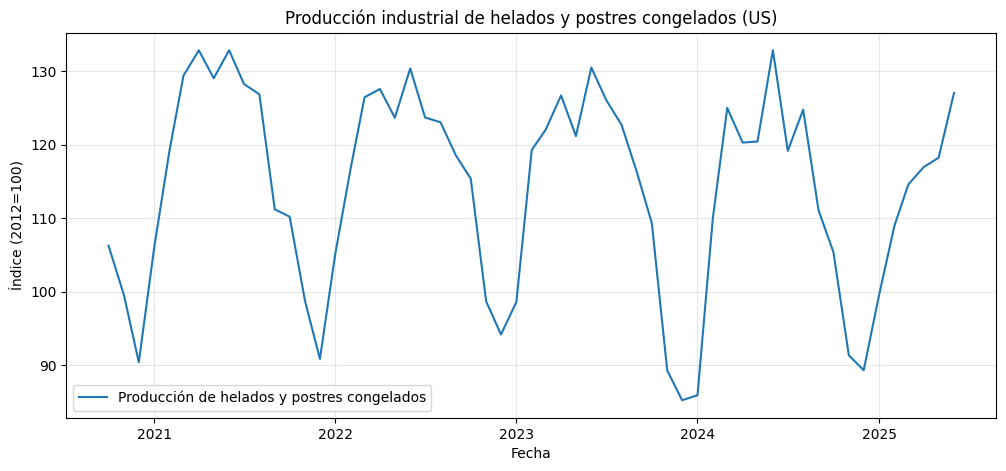

In [220]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df["value"], label="Producción de helados y postres congelados")
plt.title("Producción industrial de helados y postres congelados (US)")
plt.xlabel("Fecha")
plt.ylabel("Índice (2012=100)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Al vere la gráfica, nos podemos dar cuenta que existe un factor de temporada sumamente alta en la producción de helados y postres congelados. Esto tiene sentido, ya que uno esperaría que la producción de helados aumente durante los meses más calurosos. También podemos graficas un año en específico para identificar temporadas altas.

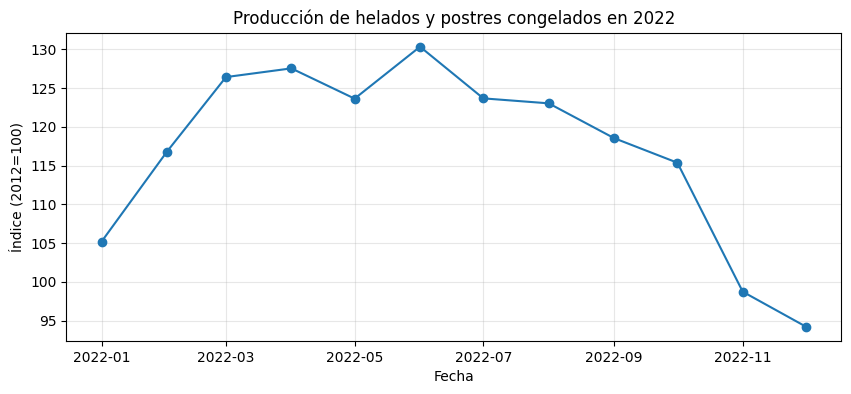

,value
DATE,
2022-01-01,105.1797
2022-02-01,116.7921
2022-03-01,126.4252
2022-04-01,127.5502
2022-05-01,123.6430
2022-06-01,130.3437
2022-07-01,123.6779
2022-08-01,123.0368
2022-09-01,118.5440


In [221]:
# Elegir el año
year = 2022
df_year = df.loc[str(year)]

plt.figure(figsize=(10,4))
plt.plot(df_year.index, df_year["value"], marker="o")
plt.title(f"Producción de helados y postres congelados en {year}")
plt.xlabel("Fecha")
plt.ylabel("Índice (2012=100)")
plt.grid(True, alpha=0.3)
plt.show()

df_year


Al graficar el año de 2022, podemos darnos cuenta que efectivamente la producción de helados y postres congelados suele aumentar en los meses más calurosos del año.

# 2. Division de Conjuntos
Para la divisón de conjuntos, simplemente tomamos valores del dataset utilizando los índices. Adicionalmente, podemos graficarlos

Rango entrenamiento: 2020-10-01 -> 2023-06-01 (33 puntos)
Rango prueba: 2023-07-01 -> 2025-06-01 (24 puntos)


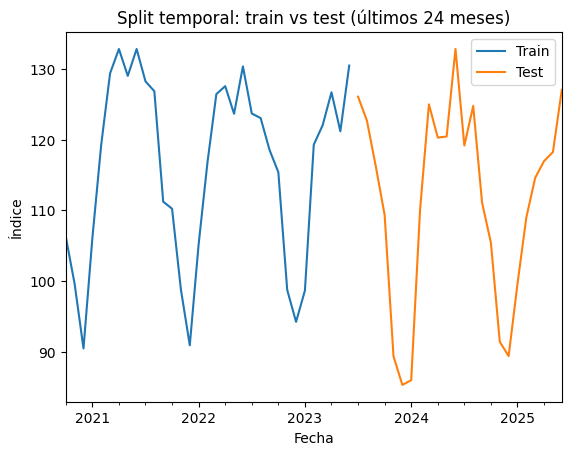

In [222]:
train = df.iloc[:-24].copy()
test = df.iloc[-24:].copy()

print("Rango entrenamiento:", train.index.min().date(), "->", train.index.max().date(), f"({len(train)} puntos)")
print("Rango prueba:", test.index.min().date(), "->", test.index.max().date(), f"({len(test)} puntos)")

# Visualización
plt.figure()
train["value"].plot(label="Train")
test["value"].plot(label="Test")
plt.title("Split temporal: train vs test (últimos 24 meses)")
plt.xlabel("Fecha")
plt.ylabel("Índice")
plt.legend()
plt.show()

# 3. Normalización y Preparación
Para normalizar los datos, podemos simplemente utilizar un MinMaxScaler con un feature range de 0 a 1. Luego, podemos preparar los datos utilizando un TimeseriesGenerator con los siguientes parámetros:

- Window Size 12 para predecir utilizando un año completo
- Batch Size 1 por el tamaño reducido del dataset
- Horizon 1 para predecir mes por mes

In [223]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train[["value"]].values)

train_scaled = scaler.transform(train[["value"]].values)
test_scaled = scaler.transform(test[["value"]].values)

# Parámetros para el generador
WINDOW_SIZE = 12
BATCH_SIZE  = 1
HORIZON     = 1

train_gen = TimeseriesGenerator(
    data=train_scaled,
    targets=train_scaled,
    length=WINDOW_SIZE,
    batch_size=BATCH_SIZE
)

val_gen = TimeseriesGenerator(
    data=test_scaled,
    targets=test_scaled,
    length=WINDOW_SIZE,
    batch_size=BATCH_SIZE
)

print(f"Batches en train_gen: {len(train_gen)} | WINDOW_SIZE={WINDOW_SIZE} | BATCH_SIZE={BATCH_SIZE}")
print(f"Batches en val_gen:   {len(val_gen)}")

# Función auxiliar para invertir el escalado luego
def inverse_scale(y_scaled):
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    return scaler.inverse_transform(y_scaled).ravel()

Batches en train_gen: 21 | WINDOW_SIZE=12 | BATCH_SIZE=1
Batches en val_gen:   12


# 4 y 5. Construccion del Modelos, Entrenamiento y Evaluación
Para este inciso, iniciaremos con modelos simples utilizando una única capa. Luego, indagaremos más a profundidad con modelos que utilizan features adicionales.

## Modelos Simples
Para estos modelos estaremos utilizando una única capa, donde estaremos variando la cantidad de neuronas dependiendo del modelo. Estaremos implementando modelos de 16, 32, 64 y 128 neuronas.

### Creación y Entrenamiento

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


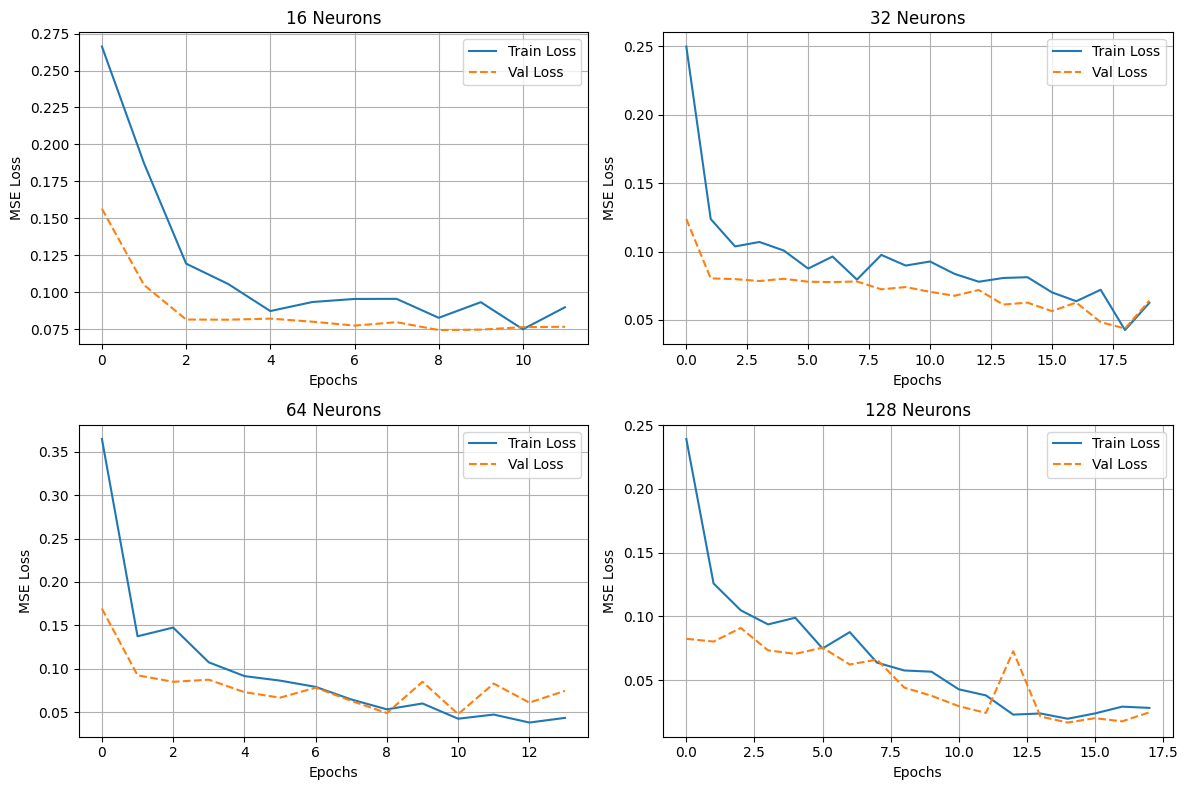

In [224]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

neuron_sizes = [16, 32, 64, 128]

histories = {}
models = {}

for n in neuron_sizes:

    model = Sequential([
        LSTM(n, activation="relu", input_shape=(WINDOW_SIZE, 1), return_sequences=False),
        Dropout(0.05),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
        verbose=0
    )

    # Store
    histories[n] = history
    models[n] = model

# --- Plotting all loss curves in grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, n in zip(axes, neuron_sizes):
    history = histories[n]
    ax.plot(history.history["loss"], label="Train Loss")
    ax.plot(history.history["val_loss"], linestyle="--", label="Val Loss")
    ax.set_title(f"{n} Neurons")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MSE Loss")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

Basado en las gráficas de pérdida de cada modelo, podemos observar ciertos patrones. Los modelos con bajas neuronas parecen converger de manera estable, sin embargo sus valores de pérdida parecen ser más altos, es decir, no pueden captar las relaciones más complicadas dentro del set de datos. Al aumentar la cantidad de neuronas a 64, logramos ver que converge a valores mucho más pequeños pero vemos un descenso de gradiente menos estable. Esto se ve de una manera mucho más evidente al utilizar 128 neuronas, dónde existen múltiples "spikes" en las pérdidas de entrenamiento. Al ver los valores de pérdida, podemos concluir que el modelo más exitoso es el de 128 neuronas. Sin embargo, hay que tener cuidado e incluir diferentes medidas para evitar el overfitting al utilizar este tipo de modelos.

### Evaluación

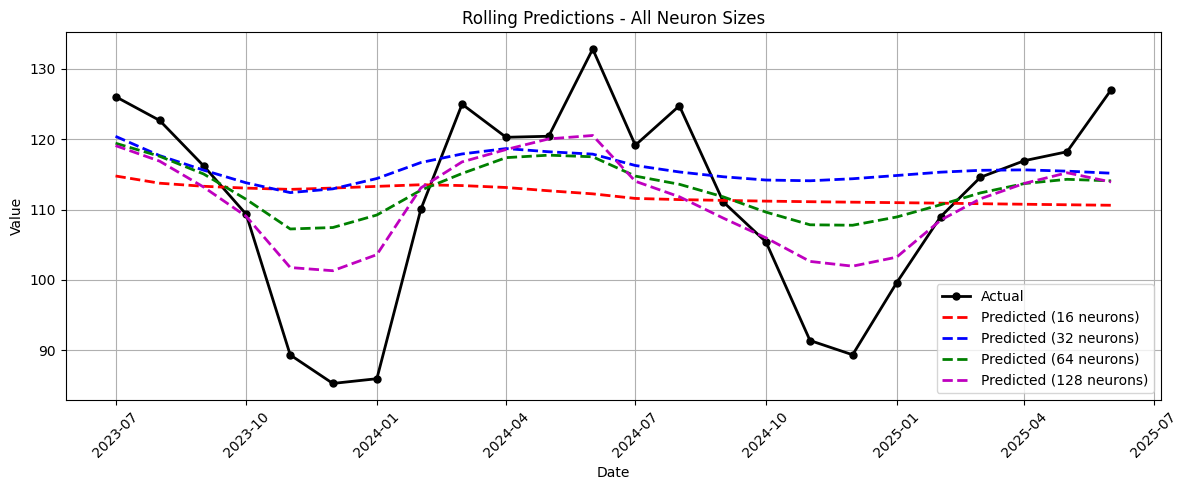

In [226]:
import numpy as np
import matplotlib.pyplot as plt

neuron_sizes = [16, 32, 64, 128]

all_preds_inv = {}

for n in neuron_sizes:
    model = models[n]

    window = train_scaled[-WINDOW_SIZE:].flatten().tolist()
    preds = []

    for _ in range(len(test_scaled)):
        x_input = np.array(window[-WINDOW_SIZE:]).reshape(1, WINDOW_SIZE, 1)
        yhat = model.predict(x_input, verbose=0)[0, 0]
        preds.append(yhat)
        window.append(yhat)

    preds_inv = inverse_scale(preds)
    all_preds_inv[n] = preds_inv

actual_inv = inverse_scale(test_scaled)

plt.figure(figsize=(12, 5))
plt.plot(test.index, actual_inv, 'ko-', label="Actual", linewidth=2, markersize=5)

colors = ['r', 'b', 'g', 'm']
for n, c in zip(neuron_sizes, colors):
    plt.plot(test.index, all_preds_inv[n], linestyle='--', color=c, label=f"Predicted ({n} neurons)", linewidth=2)

plt.title("Rolling Predictions - All Neuron Sizes")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Observando el rendimiento de los modelos, parece que en general todos parecen captar las relaciones a grandes rasgos. Por ejemplo, en cada una de las lineas se logran observar los aumentos / descensos de temporada. Sin embargo, la diferencia yace en que tanta "confianza" tienen en predecir estos aumentos y descensos. Por ejemplo, el modelo de 16 neuronas suele quedarse más alrededor de una tendencia central, mientras que los modelos de más neuronas ascienden / descienden más. En este caso, el modelo con el mejor rendimiento es el de 128 neuronas. Al observar los picos y las caídas, es el modelo que mejor predice estos cambios rápidos al llegar a temporadas altas / bajas. Sin embargo, todavía no es capaz de captar las relaciones a profundidad por lo que podemos explorar modelos más complejos.

## Modelos Complejos
En esta sección estaremos investigando modelos un poco más complejos, o más "originales". Vamos a experimentar con diferentes cantidades de capas, capas densas, capas más anchas y dropout recurrente.

### Creación y Entrenamiento
Vamos a estar trabajando con los siguientes modelos:

Stacked LSTM
- **Capa LSTM:** 64 neuronas, activación `relu`, `return_sequences=True`
- **Dropout:** 0.2
- **Capa LSTM:** 32 neuronas, activación `relu`
- **Dropout:** 0.2

---

LSTM + Dense
- **Capa LSTM:** 64 neuronas, activación `tanh`
- **Dropout:** 0.2
- **Capa densa escondida:** 32 neuronas, activación `relu`
- **Dropout:** 0.1

---

Wider LSTM
- **Capa LSTM:** 96 neurons, activación `relu`
- **Dropout:** 0.2

---

Dropout + Recurrent Dropout
- **Capa LSTM:** 64 neuronas, activación `tanh`, `recurrent_dropout=0.1`
- **Dropout:** 0.2

Training Stacked LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM + Dense...
Training Wider LSTM...
Training Dropout + recurrent_dropout...


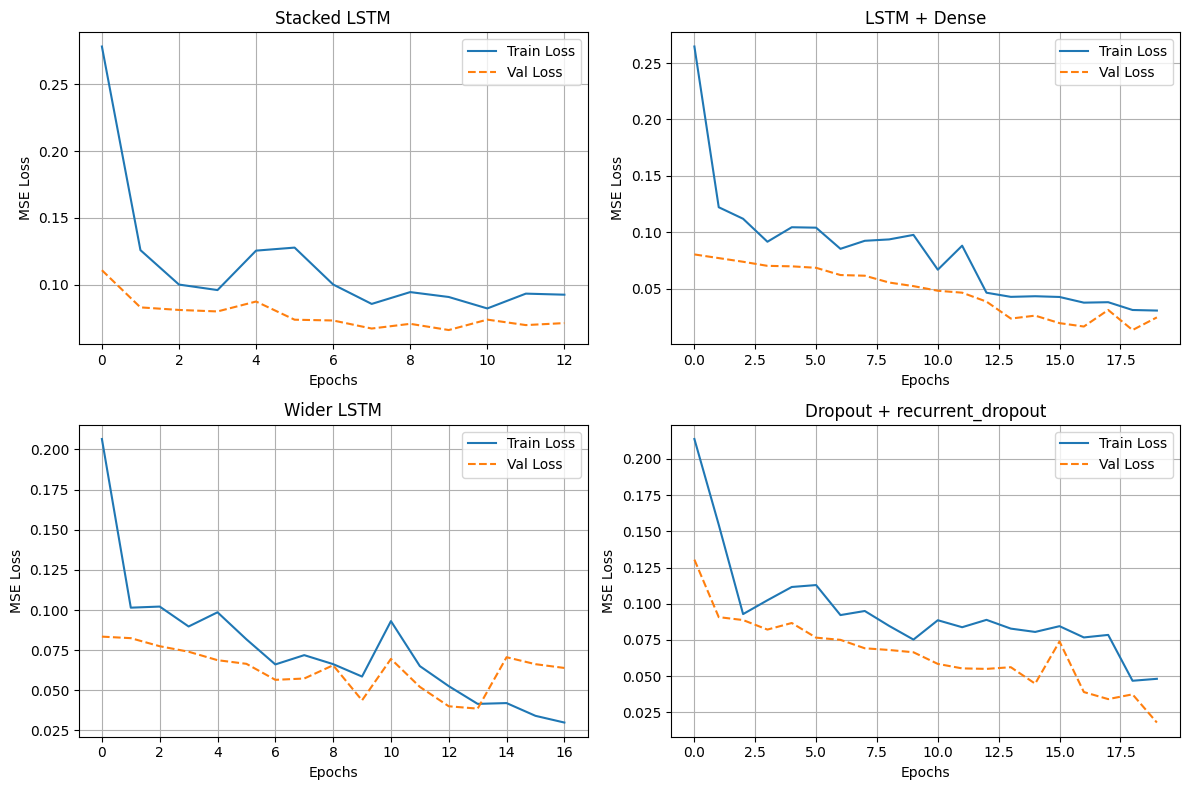

In [227]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

model_configs = {
    "Stacked LSTM": {
        "builder": lambda: Sequential([
            LSTM(64, activation="relu", return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
            Dropout(0.2),
            LSTM(32, activation="relu"),
            Dropout(0.2),
            Dense(1)
        ]),
        "notes": "64→32 neurons, stacked layers"
    },
    "LSTM + Dense": {
        "builder": lambda: Sequential([
            LSTM(64, activation="tanh", input_shape=(WINDOW_SIZE, 1)),
            Dropout(0.2),
            Dense(32, activation="relu"),
            Dropout(0.1),
            Dense(1)
        ]),
        "notes": "LSTM followed by Dense layer"
    },
    "Wider LSTM": {
        "builder": lambda: Sequential([
            LSTM(96, activation="relu", input_shape=(WINDOW_SIZE, 1)),
            Dropout(0.2),
            Dense(1)
        ]),
        "notes": "Slightly larger single LSTM layer"
    },
    "Dropout + recurrent_dropout": {
        "builder": lambda: Sequential([
            LSTM(64, activation="tanh", recurrent_dropout=0.1, input_shape=(WINDOW_SIZE, 1)),
            Dropout(0.2),
            Dense(1)
        ]),
        "notes": "Extra recurrent dropout for regularization"
    }
}

histories = {}
models = {}

for name, config in model_configs.items():
    print(f"Training {name}...")
    model = config["builder"]()
    model.compile(optimizer="adam", loss="mse")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
        verbose=0
    )

    models[name] = model
    histories[name] = history

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (name, history) in zip(axes, histories.items()):
    ax.plot(history.history["loss"], label="Train Loss")
    ax.plot(history.history["val_loss"], linestyle="--", label="Val Loss")
    ax.set_title(name)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MSE Loss")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Dentro de los modelos más complejos podemos ver algunos patrones interesantes, por ejemplo, el LSTM stacked tuvo un rendimiento bastante pobre en comparación aún a los modelos más simples. Esto se puede deber al parámetro de paciencia en cuanto al early stopping o un dropout demasiado agresivo tomando en cuenta el tamaño del set de datos. Continuando con el siguiente modelo, el LSTM con una capa densa tuvo un rendimiento bastante alto y la curva de pérdida parece tener bastante estabilidad. No exhibe signos de overfitting y llega a una pérdida de validación bastante baja. Luego, el LSTM más ancho exhibe problemas severos de overfitting. Este modelo tuvo bastante problemas para converger, viendo múltiples picos y parando en valores de pérdida bastante altos. Por último, otro modelo prometedor es el que incluye dropout recurrente. La inclusión del dropout recurrente comprobó tener resultados bastante exitosos en cuanto a la pérdida de prueba, siendo esta estable e indicando que este modelo tiene una alta capacidad de generalización.

### Evaluación

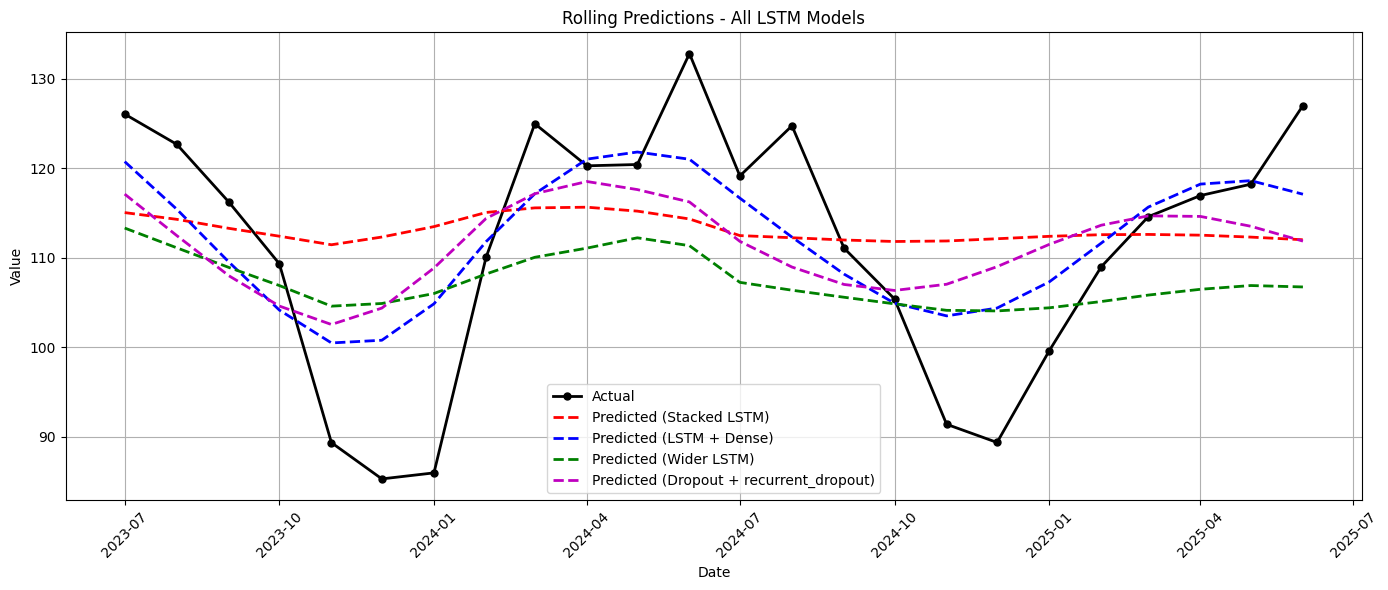

In [228]:
import numpy as np
import matplotlib.pyplot as plt

# Names of your models
model_names = ["Stacked LSTM", "LSTM + Dense", "Wider LSTM", "Dropout + recurrent_dropout"]

# Dictionary to store predictions
all_preds_inv = {}

for name in model_names:
    model = models[name]

    window = train_scaled[-WINDOW_SIZE:].flatten().tolist()
    preds = []

    for _ in range(len(test_scaled)):
        x_input = np.array(window[-WINDOW_SIZE:]).reshape(1, WINDOW_SIZE, 1)
        yhat = model.predict(x_input, verbose=0)[0, 0]
        preds.append(yhat)
        window.append(yhat)

    preds_inv = inverse_scale(preds)
    all_preds_inv[name] = preds_inv

actual_inv = inverse_scale(test_scaled)

plt.figure(figsize=(14, 6))
plt.plot(test.index, actual_inv, 'ko-', label="Actual", linewidth=2, markersize=5)

colors = ['r', 'b', 'g', 'm']
for name, color in zip(model_names, colors):
    plt.plot(test.index, all_preds_inv[name], linestyle='--', color=color,
             label=f"Predicted ({name})", linewidth=2)

plt.title("Rolling Predictions - All LSTM Models")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Observando las predicciones, los modelos más adecuados parecen ser Recurrent Dropout y LSTM + Dense. En este caso, son los modelos que siguen los patrones de los datos de la mejor manera. Debido a esto, podemos recomendar experimentar con la inclusión de capas densas al igual que dropout recurrente para modelos futuros. Adicionalmente, consideramos que algunos de estos parámetros pueden ser de especial utilidad en sets con una mayor cantidad de datos. Ya que, con una mayor cantidad de datos es posible utilizar modelos más complejos con menor riesgo de overfitting y puede ser de utilidad aplicar algunas de estas técnicas. Por ejemplo, incluir una capa densa para mejorar el rendimiento del modelo y experimentar con dropout recurrente para aumentar su capacidad de generalizar.

# 6. Análisis y Discusión
## Resultados
Dentro de los modelos utilizados, los más exitosos fueron los que incluyeron algunos features más experimentales como lo pueden ser una capa densa y dropout recurrente. Sin embargo, debido al tamaño del set de datos los modelos simples (con una única capa LSTM y una cantidad variable de neuronas) lograron tener un rendimiento bastante alto. Luego de haber realizado este laboratorio, podemos recomendar altamente iniciar con modelos más simples e ir aumentando la complejidad basado en necesidades o complejidades dentro del set de datos. Para algunos casos de uso, puede que sea suficiente incluir modelos más simples antes de intentar aplicar modelos complejos. Adicionalmente, es clave monitorear las curvas de pérdida para asegurar un aprendizaje adecuado de los modelos e ir variando parámetros. En el caso de los modelos implementados, logramos identificar varios casos de overfitting o descensos de gradiente inconsistenites. En un trabajo de la vida real, puede que esto marque la diferencia entre predicciones precisas o predicciones basadas principalmente en el conjunto de entrenamiento

## Limitaciones
Consideramos que la mayor limitación para este laboratorio es el tamaño del conjunto de datos. A pesar de tener datos a lo largo de 5 años, algunos modelos más complejos realmente no son aptos para este caso de uso. Estos tienden a memorizarse los features del conjunto de entrenamiento y esto limita la experimentación con arquitectura. Adicionalmente, la aleatoriedad juega un factor importante en el entrenamiento de estos modelos. Durante las diferentes corridas de este Notebook, nos dimos cuenta que conforme cada corrida las predicciones variaban significativamente.

## Mejoras Posibles
Sugerimos recoletar u obtener más puntos históricos o utilizar datos sintéticos para poder experimentar con modelos más complejos, al igual que implementar una reproducibilidad más robusta para facilitar las comparaciones de modelos. Adicionalmente, recomendamos a cualquier persona que desee ampliar sobre este análisis tomar en cuenta los resultados obtenidos utiliando dropout recurrente y capas densas. Ya que al experimentar aún más a profundidad, puede que se encuentren mejores modelos.